<a href="https://colab.research.google.com/github/tanyachopra08/102116069-SESS-LE1/blob/main/102116069_tanya_chopra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Tanya Chopra
102116069
4CS11
Email: tchopra1_be21@thapar.edu
SESS_LE1

In [ ]:
##Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

In [ ]:
The paper introduces the Speech Commands dataset, designed to advance
keyword spotting systems by providing a standardized dataset of spoken words. This dataset allows
researchers to build and test small models for detecting specific words amidst background noise.
Released under the Creative Commons BY 4.0 license, it aims to support reproducible research and
comparisons in keyword spotting, addressing the need for accessible and specialized datasets
beyond traditional speech recognition resources.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import zipfile
import os

# Define the path to the zip file in Google Drive and the extraction directory
zip_file_path = '/content/drive/MyDrive/speech_commands_v0.02.zip'
extract_dir = '/content/speech_commands_v0.02'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [8]:
# List the contents of the extraction directory
os.listdir(extract_dir)


['__MACOSX', 'speech_commands_v0.02']

In [11]:
!pip install pydub

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split=['train', 'validation', 'test'])

# Extract splits
train_data, val_data, test_data = dataset

# Print dataset info
print(info)


tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or

Training set lengths - Mean: 15693.86, Std: 1141.16
Validation set lengths - Mean: 15693.11, Std: 1154.05
Test set lengths - Mean: 16000.00, Std: 0.00


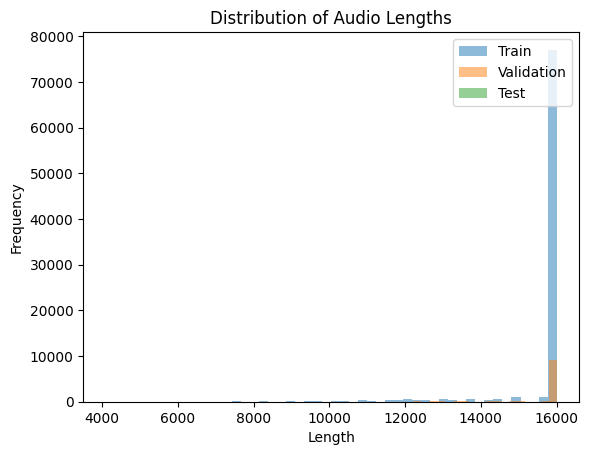

In [8]:
#statistical analysis
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Function to collect audio lengths
def collect_audio_lengths(dataset):
    audio_lengths = []
    for audio, _ in dataset:
        audio_length = tf.shape(audio)[0].numpy()
        audio_lengths.append(audio_length)
    return audio_lengths

# Collect audio lengths
train_lengths = collect_audio_lengths(train_data)
val_lengths = collect_audio_lengths(val_data)
test_lengths = collect_audio_lengths(test_data)

# Print statistics
print("Training set lengths - Mean: {:.2f}, Std: {:.2f}".format(np.mean(train_lengths), np.std(train_lengths)))
print("Validation set lengths - Mean: {:.2f}, Std: {:.2f}".format(np.mean(val_lengths), np.std(val_lengths)))
print("Test set lengths - Mean: {:.2f}, Std: {:.2f}".format(np.mean(test_lengths), np.std(test_lengths)))

# Plot audio lengths distribution
plt.hist(train_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(val_lengths, bins=50, alpha=0.5, label='Validation')
plt.hist(test_lengths, bins=50, alpha=0.5, label='Test')
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [9]:
#preprocessing
import tensorflow as tf
import tensorflow_datasets as tfds

# Define preprocessing functions
def preprocess_audio(audio, target_length=16000):
    audio = tf.cast(audio, tf.float32) / 32768.0  # Normalize
    audio_length = tf.shape(audio)[0]

    # Calculate padding size
    pad_size = tf.maximum(target_length - audio_length, 0)

    # Pad or slice the audio
    audio = tf.cond(
        pad_size > 0,
        lambda: tf.pad(audio, [[0, pad_size]]),  # Pad if shorter
        lambda: audio[:target_length]  # Slice if longer
    )
    return audio

def preprocess(example, label):
    audio = preprocess_audio(example)
    audio = tf.expand_dims(audio, axis=-1)  # Add channel dimension
    return audio, label

# Load dataset
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split=['train', 'validation', 'test'])
train_data, val_data, test_data = dataset

# Apply preprocessing
train_data = (train_data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_data
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))

test_data = (test_data
             .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
             .batch(32)
             .prefetch(tf.data.AUTOTUNE))



In [10]:
# Inspect a batch from the train dataset
for example, label in train_data.take(1):
    print(f'Example shape: {example.shape}')
    print(f'Label shape: {label.shape}')


Example shape: (32, 16000, 1)
Label shape: (32,)


In [11]:
class_names = info.features['label'].names
print("Class Names:")
for i, name in enumerate(class_names):
    print(f"Label {i}: {name}")

Class Names:
Label 0: down
Label 1: go
Label 2: left
Label 3: no
Label 4: off
Label 5: on
Label 6: right
Label 7: stop
Label 8: up
Label 9: yes
Label 10: _silence_
Label 11: _unknown_


In [3]:
# Define the mapping of label indices to class names
label_names = {
    0: 'down',
    1: 'go',
    2: 'left',
    3: 'no',
    4: 'off',
    5: 'on',
    6: 'right',
    7: 'stop',
    8: 'up',
    9: 'yes',
    10: '_silence_',
    11: '_unknown_'
}


In [4]:
num_labels = len(label_names)
num_labels

12

In [12]:
import tensorflow as tf

# Load your dataset (assuming it's a TensorFlow dataset)
# train_data = tf.data.Dataset.from_tensor_slices((audio_data, labels))
# For demonstration, we'll assume train_data is already defined

# Function to extract a few examples from the dataset
def get_examples(dataset, num_examples=3):
    example_audios = []
    example_labels = []

    for audio, label in dataset.take(num_examples):
        example_audios.append(audio.numpy())  # Convert Tensor to numpy array
        example_labels.append(label.numpy())

    return example_audios, example_labels

# Get a few examples from the dataset
example_audios, example_labels = get_examples(train_data, num_examples=3)

# Print the shapes of the examples to verify
for i in range(len(example_audios)):
    print(f"Example {i}:")
    print("Audio shape:", example_audios[i].shape)
    print("Label:", example_labels[i])


Example 0:
Audio shape: (32, 16000, 1)
Label: [11  8 11 11  5  4  1 11 10 11 11 11 11  1 11  6 11 11 11  5  3 11  2 11
  3 11 11 11  5 11 11 11]
Example 1:
Audio shape: (32, 16000, 1)
Label: [11 11  8  2  7 11 11  2 11 11  2 11 11 11 11  6  1  9  4 11  9  3 11 11
  3 11 11 11 11 11  9 11]
Example 2:
Audio shape: (32, 16000, 1)
Label: [ 5 11  6 11  3 11 11 11 11  2  7 11  1 11  4  9  7 11 11 11  7  1 11 11
 11 11 11 11 11  8  5  1]


Example 0:
Audio shape: (32, 16000, 1)
Label: [11  0  7 11  2 11 11  2  3  4 11 11 11 10 11 11 11 11 11 11 11 11  8  3
 11 11  4 11  7 11 11 11]
Audio playback:


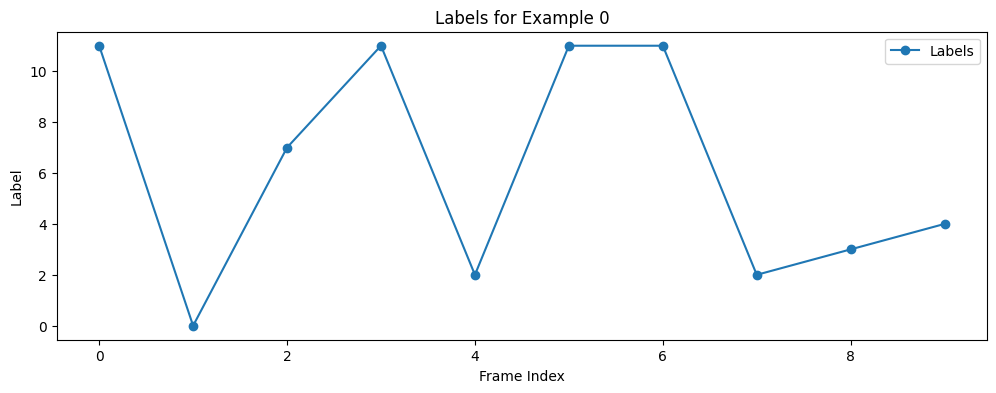

Example 1:
Audio shape: (32, 16000, 1)
Label: [11  1 11 11 11 11  1 11  4 11  7 11  0  7 11 11  2 11  2 11 11  1  7 11
 11  5 11 11 11 11 11  9]
Audio playback:


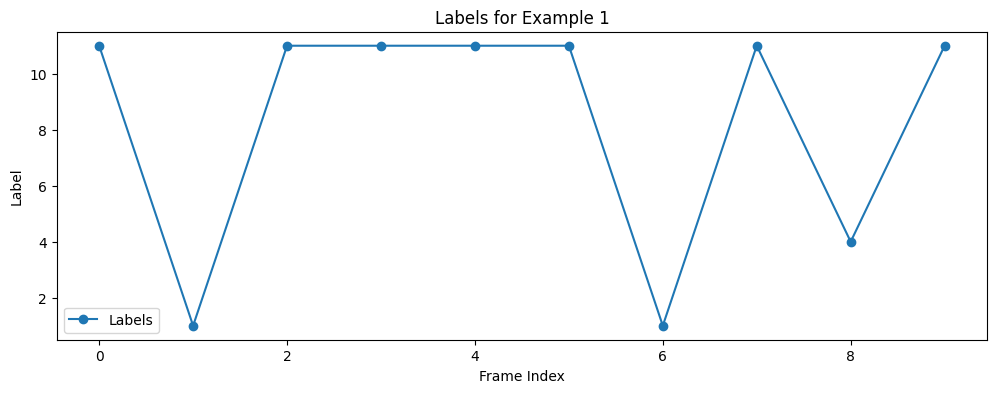

Example 2:
Audio shape: (32, 16000, 1)
Label: [ 2  9 11 11  1 11 11  0  7 11 11 11  4 11  9 11 11 11 11  2 11  2 11 11
 11 11 11 11 11  7  0 11]
Audio playback:


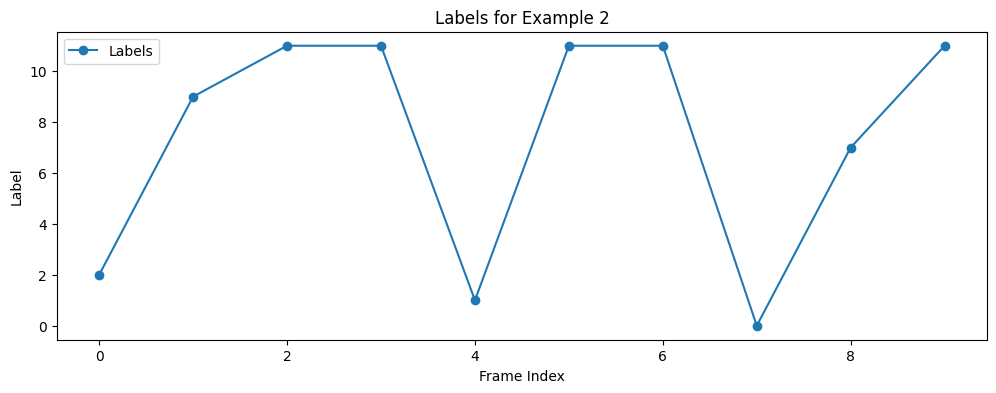

In [52]:
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt

def get_scalar_label(label_array):
    """Extract scalar values from label array."""
    if isinstance(label_array, np.ndarray):
        if label_array.size == 1:
            return label_array.item()
        else:
            return label_array
    else:
        return label_array

def display_example(example_index):
    # Assuming example_audios and example_labels are lists or arrays of examples
    audio = example_audios[example_index]
    labels = example_labels[example_index]

    # Print waveform shape and labels
    print(f"Example {example_index}:")
    print("Audio shape:", audio.shape)
    print("Label:", labels)

    # Display audio for the example
    print('Audio playback:')
    display.display(display.Audio(audio[0], rate=16000))  # Adjust index if needed

    # Plot the first few frames and their labels
    num_frames_to_plot = min(len(labels), 10)  # Adjust as needed
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_frames_to_plot), labels[:num_frames_to_plot], 'o-', label='Labels')
    plt.xlabel('Frame Index')
    plt.ylabel('Label')
    plt.title(f'Labels for Example {example_index}')
    plt.legend()
    plt.show()

# Display the first 3 examples
for i in range(3):
    display_example(i)




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape based on your audio data
input_shape = (16000, 1)  # (length, channels)
num_labels = len(label_names)  # Number of unique labels

# Define the model
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')  # Use softmax for multi-class classification
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=6,
                    verbose=1)




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 16000, 64)           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,788 (233.55 KB)

 Trainable params: 59,788 (233.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 2247s 838ms/step - accuracy: 0.6313 - loss: 1.5842 - val_accuracy: 0.6215 - val_loss: 1.5634
Epoch 2/6
1672/2673 ━━━━━━━━━━━━━━━━━━━━ 12:49 769ms/step - accuracy: 0.6342 - loss: 1.5354